In [55]:
#Python libraries
import matplotlib.pyplot as plt 
import MetaTrader5 as mt5
import tensorflow as tf
import numpy as np
import pandas as pd
import tf2onnx
from sklearn.model_selection import train_test_split
from sys import argv

# Check GPU

In [56]:
#check tensorflow version
print(tf.__version__)
#check GPU support
print(len(tf.config.list_physical_devices('GPU'))>0)

2.15.0
False


In [57]:
#initialize MetaTrader5 for history data
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

In [58]:
#show terminal info
terminal_info=mt5.terminal_info()
print(terminal_info)

TerminalInfo(community_account=True, community_connection=True, connected=True, dlls_allowed=True, trade_allowed=True, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=False, build=4275, maxbars=100000, codepage=0, ping_last=158844, community_balance=0.0, retransmission=0.010518786552783271, company='MetaQuotes Software Corp.', name='MetaTrader 5', language='English', path='C:\\Program Files\\MetaTrader 5', data_path='C:\\Users\\amsb9\\AppData\\Roaming\\MetaQuotes\\Terminal\\D0E8209F77C8CF37AD8BF550E51FF075', commondata_path='C:\\Users\\amsb9\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')


In [59]:
#show file path
file_path=terminal_info.data_path+"\\MQL5\\Experts\\alcoModel\\"
print(file_path)

C:\Users\amsb9\AppData\Roaming\MetaQuotes\Terminal\D0E8209F77C8CF37AD8BF550E51FF075\MQL5\Experts\alcoModel\


In [60]:
#data path to save the model
data_path=argv[0]
last_index=data_path.rfind("\\")+1
data_path=data_path[0:last_index]
print("data path to save onnx model",data_path)

data path to save onnx model C:\Users\amsb9\AppData\Roaming\Python\Python311\site-packages\


# Load Data

In [61]:
#set start and end dates for history data
from datetime import timedelta,datetime
end_date = datetime.now()
start_date = end_date - timedelta(days=120)

#print start and end dates
print("data start date=",start_date)
print("data end date=",end_date)

data start date= 2023-12-21 18:19:42.903686
data end date= 2024-04-19 18:19:42.903686


In [62]:
#get EURUSD rates (H1) from start_date to end_date
eurusd_rates = mt5.copy_rates_range("EURUSD", mt5.TIMEFRAME_H1, start_date, end_date)

In [63]:
#create dataframe
df = pd.DataFrame(eurusd_rates)
df.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,1703210400,1.10057,1.10099,1.10027,1.10047,3590,1,0
1,1703214000,1.10048,1.10066,1.09970,1.09980,5571,1,0
2,1703217600,1.09980,1.10007,1.09955,1.10001,3819,1,0
3,1703221200,1.10001,1.10050,1.09957,1.09978,3913,1,0
4,1703224800,1.09978,1.10033,1.09978,1.10006,2926,1,0


In [64]:
df['datetime']=pd.to_datetime(df['time'], unit='s')

print(df['datetime'][0])
print(df['datetime'][len(df)-1])

2023-12-22 02:00:00
2024-04-19 23:00:00


# Pre-Processing

In [65]:
#prepare close prices only
data = df.filter(['close']).values

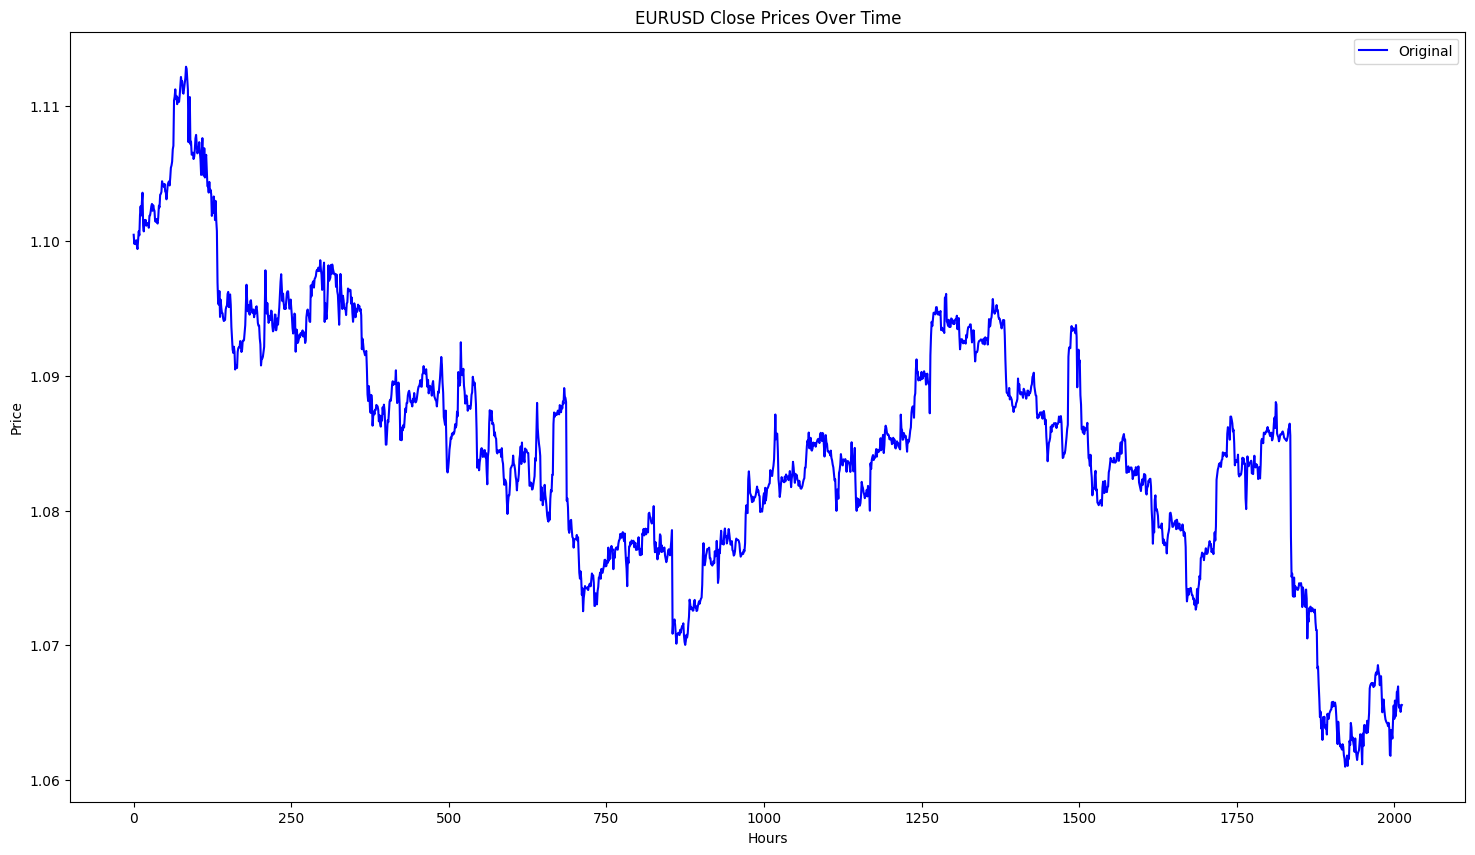

In [66]:
#show close prices
plt.figure(figsize = (18,10))
plt.plot(data,'b',label = 'Original')
plt.xlabel("Hours")
plt.ylabel("Price")
plt.title("EURUSD Close Prices Over Time")
plt.legend()

In [67]:
#scale data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [68]:
#training size is a 80/20 split
training_size = int(len(scaled_data)*0.80) 
print("training size:",training_size)

training size: 1610


In [69]:
#create train data and check size
train_data_initial = scaled_data[0:training_size,:]
print(len(train_data_initial))

1610


In [70]:
#create test data and check size
test_data_initial= scaled_data[training_size:,:1]
print(len(test_data_initial))

403


In [71]:
#split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
       #find the end of this pattern
       end_ix = i + n_steps
       #check if we are beyond the sequence
       if end_ix > len(sequence)-1:
          break
       #gather input and output parts of the pattern
       seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
       X.append(seq_x)
       y.append(seq_y)
    return np.array(X), np.array(y)

In [72]:
#split into samples
time_step = 120
x_train, y_train = split_sequence(train_data_initial, time_step)
x_test, y_test = split_sequence(test_data_initial, time_step)
#reshape input to be [samples, time steps, features] which is required for LSTM
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

# Model

In [73]:
#import keras libraries for the model
import math
from keras.models import Sequential
from keras.layers import Dense,Activation,Conv1D,MaxPooling1D,Dropout
from keras.layers import LSTM
from tensorflow.keras.utils import plot_model
from keras.metrics import RootMeanSquaredError as rmse
from keras.callbacks import EarlyStopping
from keras import optimizers

In [74]:
#define the model
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2,activation='relu',padding = 'same',input_shape=(120,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences = False))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss= 'mse' , metrics = [rmse()])

# define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

In [75]:
#measure time
import time 
time_calc_start = time.time()

#fit model with 300 epochs
history=model.fit(x_train,y_train,epochs=300,
                  validation_data=(x_test,y_test),
                  batch_size=32,
                  verbose=1, 
                  callbacks=[early_stopping]
)

#calculate time
fit_time_seconds = time.time() - time_calc_start
print("fit time =",fit_time_seconds," seconds.")

Epoch 1/300
47/47 [==============================] - 9s 76ms/step - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1218
Epoch 2/300
47/47 [==============================] - 2s 52ms/step - loss: 0.0026 - root_mean_squared_error: 0.0506 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0931
Epoch 3/300
47/47 [==============================] - 2s 52ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047
Epoch 4/300
47/47 [==============================] - 2s 53ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1079
Epoch 5/300
47/47 [==============================] - 2s 53ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0950
Epoch 6/300
47/47 [==============================] - 2s 52ms/step - loss: 9.5031e-04 - root_mean_squared_error: 0.0308 - val_loss: 0.0104 - 

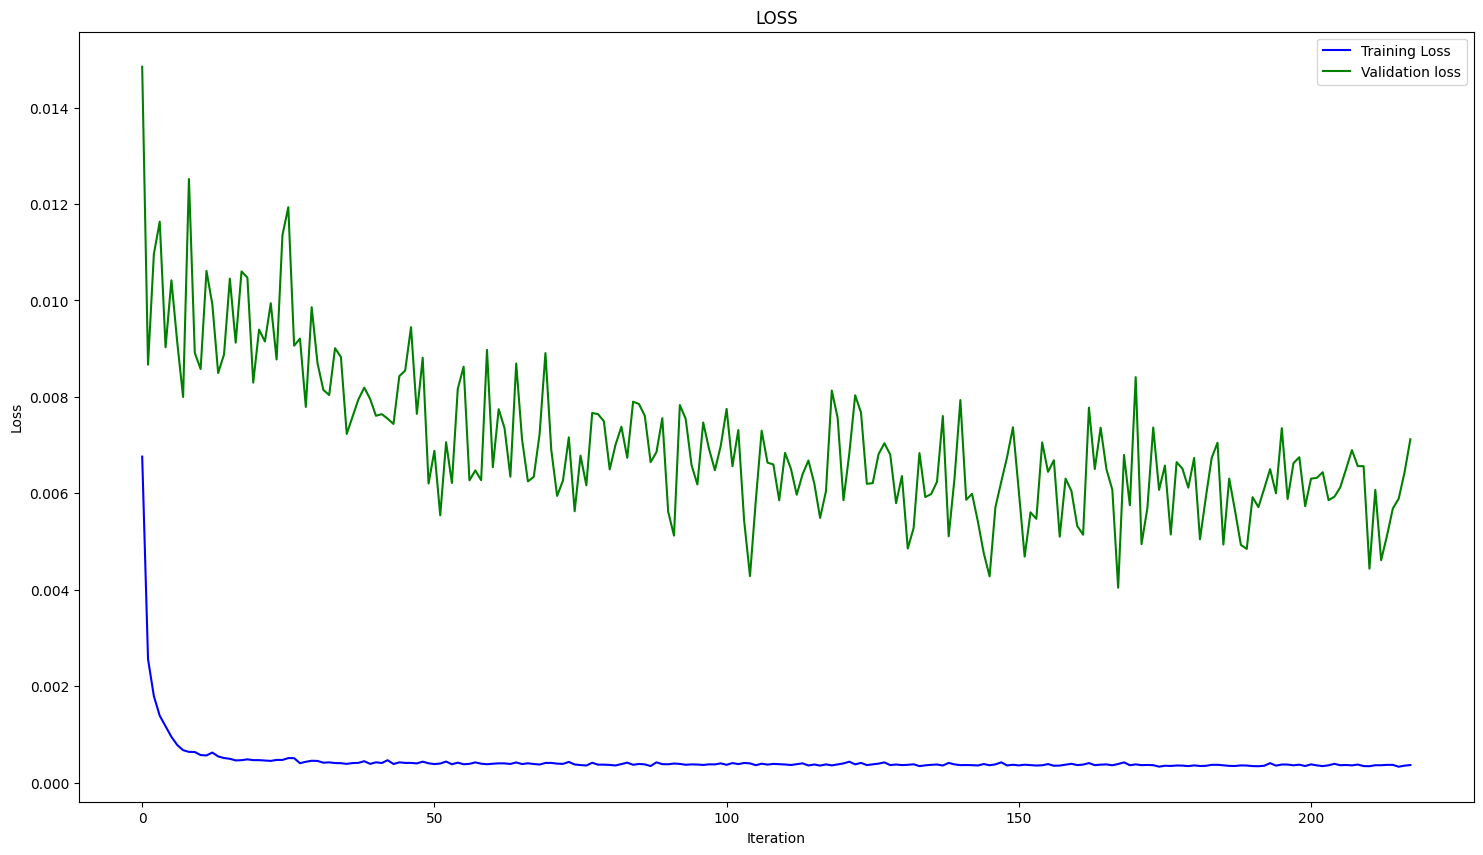

In [76]:
#show iteration-loss graph for training and validation
plt.figure(figsize = (18,10))
plt.plot(history.history['loss'],label='Training Loss',color='b')
plt.plot(history.history['val_loss'],label='Validation loss',color='g')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("LOSS")
plt.legend()

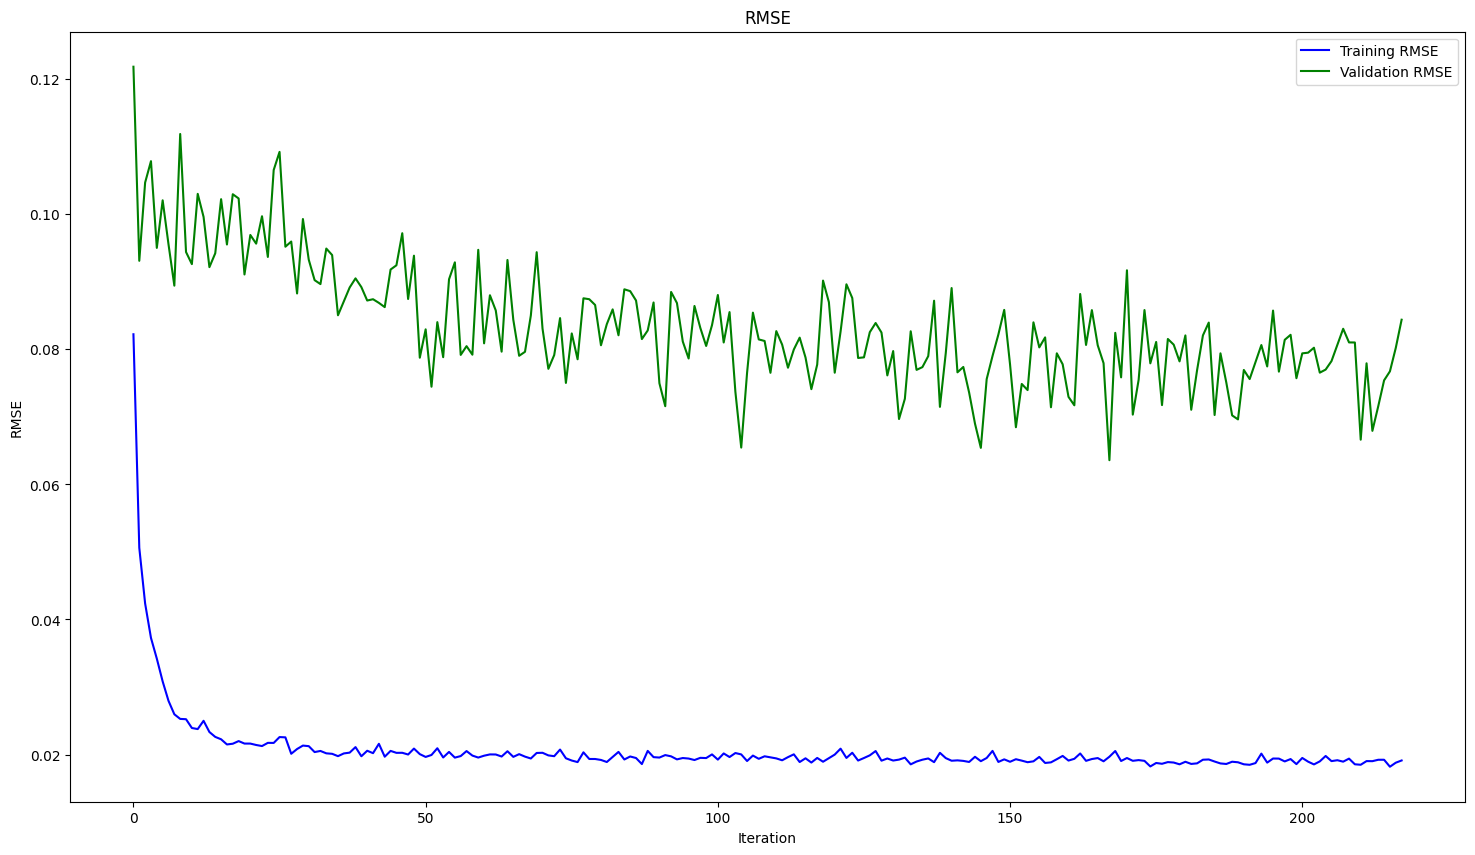

In [77]:
#show iteration-rmse graph for training and validation
plt.figure(figsize = (18,10))
plt.plot(history.history['root_mean_squared_error'],label='Training RMSE',color='b')
plt.plot(history.history['val_root_mean_squared_error'],label='Validation RMSE',color='g')
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("RMSE")
plt.legend()

# Evaluation

In [78]:
#evaluate training data
model.evaluate(x_train,y_train, batch_size = 32)

47/47 [==============================] - 1s 24ms/step - loss: 4.6148e-04 - root_mean_squared_error: 0.0215


[0.00046148215187713504, 0.021482136100530624]

In [79]:
#evaluate testing data
model.evaluate(x_test,y_test, batch_size = 32)

9/9 [==============================] - 0s 24ms/step - loss: 0.0040 - root_mean_squared_error: 0.0636


[0.004042682237923145, 0.06358209252357483]

In [80]:
#prediction using training data
train_predict = model.predict(x_train)
plot_y_train = y_train.reshape(-1,1)

47/47 [==============================] - 2s 23ms/step


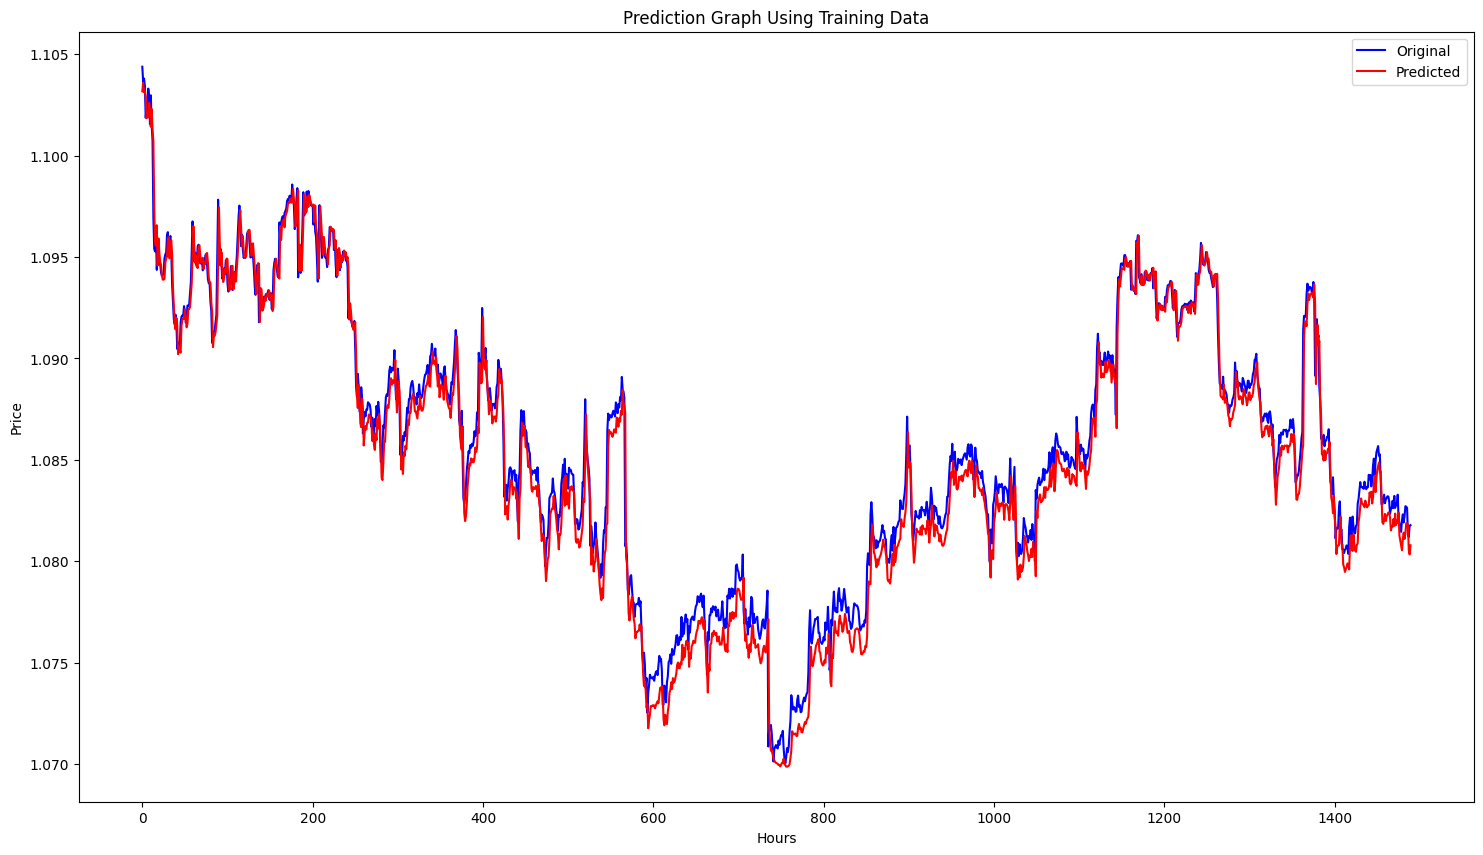

In [81]:
#show actual vs predicted (training) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_train),color = 'b', label = 'Original')
plt.plot(scaler.inverse_transform(train_predict),color='red', label = 'Predicted')
plt.title("Prediction Graph Using Training Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.legend()
plt.show()

In [82]:
#prediction using testing data
test_predict = model.predict(x_test)
plot_y_test = y_test.reshape(-1,1)

9/9 [==============================] - 0s 25ms/step


In [83]:
#calculate metrics
from sklearn import metrics
from sklearn.metrics import r2_score
#transform data to real values
value1=scaler.inverse_transform(plot_y_test)
value2=scaler.inverse_transform(test_predict)
#calc score
score = np.sqrt(metrics.mean_squared_error(value1,value2))
print("RMSE         : {}".format(score))
print("MSE          :", metrics.mean_squared_error(value1,value2))
print("R2 score     :",metrics.r2_score(value1,value2))

RMSE         : 0.00330308793051015
MSE          : 1.0910389876681824e-05
R2 score     : 0.8770120157435707


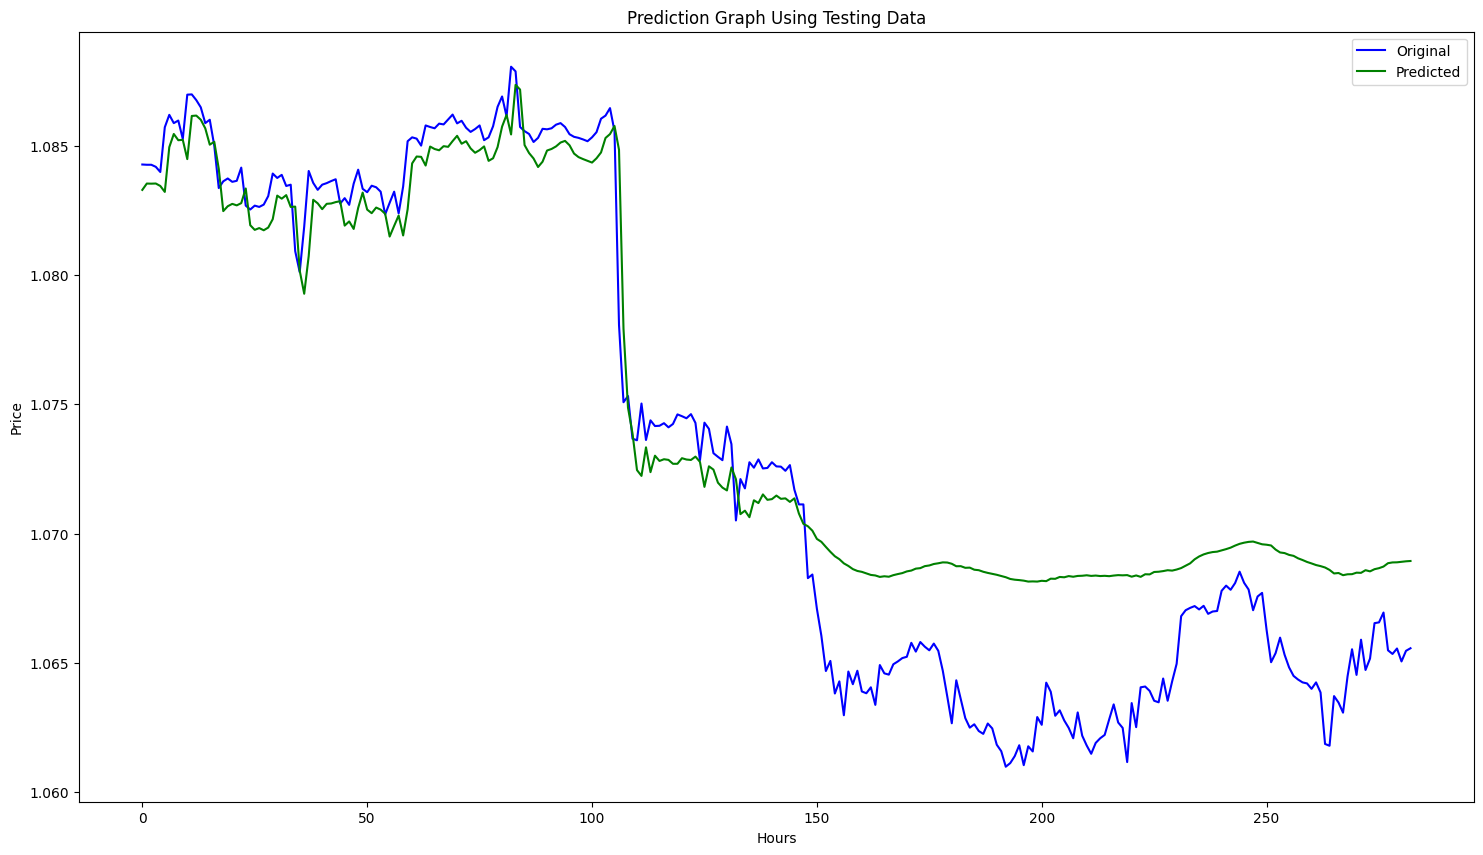

In [84]:
#show actual vs predicted (testing) graph
plt.figure(figsize=(18, 10))
plt.plot(scaler.inverse_transform(plot_y_test), color = 'b',  label = 'Original')
plt.plot(scaler.inverse_transform(test_predict), color='g', label = 'Predicted')
plt.title("Prediction Graph Using Testing Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.legend()
plt.show()

2023-08-24 01:00:00
2023-12-21 01:00:00
60/60 [==============================] - 1s 24ms/step
RMSE:  0.006383697959003951
MSE:  4.0751599631791205e-05
R2 Score:  0.803187589926772


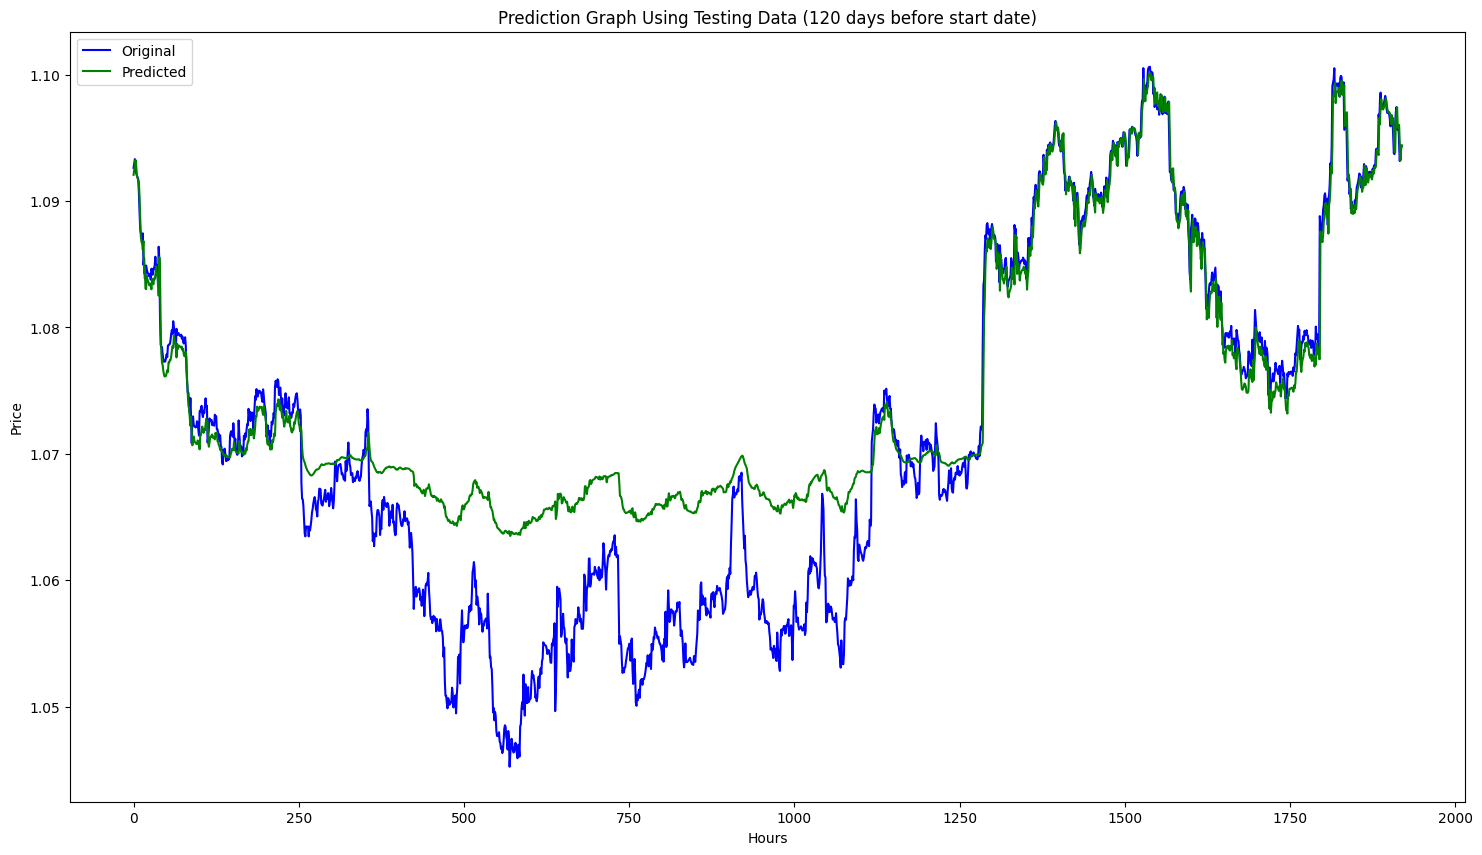

In [85]:
# Retrieve historical data for the 120 days before the start date
test_start_date = start_date - timedelta(days=120)
test_end_date = start_date - timedelta(days=1)
test_eurusd_rates = mt5.copy_rates_range("EURUSD", mt5.TIMEFRAME_H1, test_start_date, test_end_date)

# Create dataframe for testing data
test_df = pd.DataFrame(test_eurusd_rates)

# Add a datetime column to the testing data
test_df['datetime']=pd.to_datetime(test_df['time'], unit='s')

# Print the start and end dates of the testing data
print(test_df['datetime'][0])
print(test_df['datetime'][len(test_df)-1])

# Preprocess the testing data
test_data = test_df.filter(['close']).values
scaled_test_data = scaler.transform(test_data)

# Split the testing data into input sequences
x_test, y_test = split_sequence(scaled_test_data, time_step)

# Reshape the input sequences
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Use the model to predict the output sequences
test_predict = model.predict(x_test)

# Inverse transform the predicted output sequences
predicted_values = scaler.inverse_transform(test_predict)

# Calculate evaluation metrics
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))
rmse_score = np.sqrt(metrics.mean_squared_error(actual_values, predicted_values))
mse_score = metrics.mean_squared_error(actual_values, predicted_values)
r2_score = metrics.r2_score(actual_values, predicted_values)

# Print the evaluation metrics
print("RMSE: ", rmse_score)
print("MSE: ", mse_score)
print("R2 Score: ", r2_score)

# Plot the actual vs predicted graph for the testing data
plt.figure(figsize=(18, 10))
plt.plot(actual_values, color='b', label='Original')
plt.plot(predicted_values, color='g', label='Predicted')
plt.title("Prediction Graph Using Testing Data (120 days before start date)")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.legend()
plt.show()


In [86]:
# save model to ONNX
output_path = data_path+"model.eurusd.H1.120.onnx"
onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)
print(f"model saved to {output_path}")

output_path = file_path+"model.eurusd.H1.120.onnx"
onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)
print(f"saved model to {output_path}")

# finish
if(mt5.shutdown()):
    print("mt5 shutdown")

model saved to C:\Users\amsb9\AppData\Roaming\Python\Python311\site-packages\model.eurusd.H1.120.onnx
saved model to C:\Users\amsb9\AppData\Roaming\MetaQuotes\Terminal\D0E8209F77C8CF37AD8BF550E51FF075\MQL5\Experts\alcoModel\model.eurusd.H1.120.onnx
mt5 shutdown
